# Robotics Lab 1: Box Robot Beam Sensor Simulation

This notebook demonstrates a PyBullet simulation of a box robot navigating through obstacles using beam sensors.

## Features:
- 3D robot simulation with PyBullet
- 5-beam sensor system with realistic noise
- Real-time visualization of sensor data
- Obstacle avoidance behavior
- Data logging and analysis


In [1]:
# Import required libraries
import pybullet as p
import pybullet_data
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Robot and Environment Setup Functions


In [2]:
class RobotSimulation:
    def __init__(self):
        self.robot_id = None
        self.physics_client = None
        self.sensor_data = []
        self.robot_positions = []
        self.collision_count = 0
        
    def create_box_robot(self, position=[0, 0, 0.1], half_extents=[0.2, 0.2, 0.1]):
        """Create a simple box robot with collision and visual shapes"""
        try:
            collision_shape = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extents)
            visual_shape = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extents, rgbaColor=[1, 0, 0, 1])
            robot_id = p.createMultiBody(baseMass=1,
                                         baseCollisionShapeIndex=collision_shape,
                                         baseVisualShapeIndex=visual_shape,
                                         basePosition=position)
            self.robot_id = robot_id
            return robot_id
        except Exception as e:
            print(f"Error creating box robot: {e}")
            return -1

    def create_obstacles(self, radius=5.0, count=18, height=2.0):
        """Create semi-circular arrangement of obstacles"""
        try:
            colors = [[1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 1, 1], [1, 1, 0, 1]]
            half_extents = [0.15, 0.15, height / 2.0]
            obstacle_positions = []
            
            for i in range(count):
                angle = np.pi * i / (count - 1)
                x = radius * np.cos(angle)
                y = radius * np.sin(angle)
                obstacle_positions.append([x, y])
                
                color = colors[i % len(colors)]
                col_shape = p.createCollisionShape(p.GEOM_BOX, halfExtents=half_extents)
                vis_shape = p.createVisualShape(p.GEOM_BOX, halfExtents=half_extents, rgbaColor=color)
                p.createMultiBody(baseMass=0,
                                  baseCollisionShapeIndex=col_shape,
                                  baseVisualShapeIndex=vis_shape,
                                  basePosition=[x, y, half_extents[2]])
            
            self.obstacle_positions = obstacle_positions
            return obstacle_positions
        except Exception as e:
            print(f"Error creating obstacles: {e}")
            return []

    def move_robot(self, velocity=0.15, turn=False):
        """Move the robot forward or turn"""
        try:
            pos, orn = p.getBasePositionAndOrientation(self.robot_id)
            yaw = p.getEulerFromQuaternion(orn)[2]
            
            if turn:
                yaw += np.pi / 3  # 60 degree turn
                
            dx = velocity * np.cos(yaw)
            dy = velocity * np.sin(yaw)
            new_pos = [pos[0] + dx, pos[1] + dy, pos[2]]
            new_orn = p.getQuaternionFromEuler([0, 0, yaw])
            
            p.resetBasePositionAndOrientation(self.robot_id, new_pos, new_orn)
            self.robot_positions.append(new_pos[:2])  # Store x, y for visualization
            
        except Exception as e:
            print(f"Error moving robot: {e}")

    def cast_multiple_beams(self, scan_range=8.0, noise_std=0.02):
        """Cast 5 beams at different angles and return sensor data"""
        try:
            pos, orn = p.getBasePositionAndOrientation(self.robot_id)
            yaw = p.getEulerFromQuaternion(orn)[2]

            beam_angles_deg = [-40, -20, 0, 20, 40]
            beam_data = []
            distances = []

            for angle_deg in beam_angles_deg:
                angle_rad = yaw + np.deg2rad(angle_deg)
                beam_dir = [np.cos(angle_rad), np.sin(angle_rad), 0]
                beam_end = [pos[0] + scan_range * beam_dir[0],
                            pos[1] + scan_range * beam_dir[1],
                            pos[2]]

                ray_result = p.rayTest(pos, beam_end)[0]
                hit_fraction = ray_result[2]
                distance = hit_fraction * scan_range

                # Add realistic sensor noise
                noisy_distance = distance + np.random.normal(0, noise_std)
                noisy_distance = np.clip(noisy_distance, 0.0, scan_range)
                
                distances.append(noisy_distance)
                beam_data.append((noisy_distance, beam_dir, beam_end, angle_deg))

            # Store sensor data for analysis
            sensor_reading = {
                'timestamp': time.time(),
                'robot_pos': pos[:2],
                'distances': distances,
                'min_distance': min(distances)
            }
            self.sensor_data.append(sensor_reading)
            
            return pos, beam_data
        except Exception as e:
            print(f"Error casting beams: {e}")
            return [0, 0, 0], []


## 2. Visualization Functions


In [3]:
class SimulationVisualizer:
    def __init__(self, robot_sim):
        self.robot_sim = robot_sim
        self.fig, self.axes = plt.subplots(2, 2, figsize=(15, 12))
        plt.tight_layout(pad=3.0)
        
    def plot_robot_path(self):
        """Plot the robot's trajectory"""
        ax = self.axes[0, 0]
        ax.clear()
        
        if hasattr(self.robot_sim, 'obstacle_positions'):
            obs_x = [pos[0] for pos in self.robot_sim.obstacle_positions]
            obs_y = [pos[1] for pos in self.robot_sim.obstacle_positions]
            ax.scatter(obs_x, obs_y, c='red', s=100, alpha=0.7, label='Obstacles')
        
        if self.robot_sim.robot_positions:
            path_x = [pos[0] for pos in self.robot_sim.robot_positions]
            path_y = [pos[1] for pos in self.robot_sim.robot_positions]
            ax.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.7, label='Robot Path')
            ax.scatter(path_x[-1], path_y[-1], c='blue', s=200, marker='s', label='Current Position')
        
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_title('Robot Trajectory')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
    def plot_sensor_distances(self):
        """Plot real-time sensor distances"""
        ax = self.axes[0, 1]
        ax.clear()
        
        if self.robot_sim.sensor_data:
            latest_data = self.robot_sim.sensor_data[-1]
            angles = [-40, -20, 0, 20, 40]
            distances = latest_data['distances']
            
            colors = ['red' if d < 0.5 else 'orange' if d < 1.0 else 'green' for d in distances]
            bars = ax.bar(angles, distances, color=colors, alpha=0.7)
            
            ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.8, label='Stop Distance')
            ax.set_xlabel('Beam Angle (degrees)')
            ax.set_ylabel('Distance (m)')
            ax.set_title('Current Sensor Readings')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, dist in zip(bars, distances):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{dist:.2f}m', ha='center', va='bottom', fontsize=9)
    
    def plot_distance_history(self):
        """Plot minimum distance over time"""
        ax = self.axes[1, 0]
        ax.clear()
        
        if len(self.robot_sim.sensor_data) > 1:
            timestamps = [data['timestamp'] - self.robot_sim.sensor_data[0]['timestamp'] 
                         for data in self.robot_sim.sensor_data]
            min_distances = [data['min_distance'] for data in self.robot_sim.sensor_data]
            
            ax.plot(timestamps, min_distances, 'b-', linewidth=2, label='Minimum Distance')
            ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.8, label='Stop Distance')
            ax.fill_between(timestamps, 0, 0.2, alpha=0.2, color='red', label='Danger Zone')
            
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Distance (m)')
            ax.set_title('Minimum Sensor Distance Over Time')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    def plot_sensor_polar(self):
        """Plot sensor data as a simple directional chart (replaces problematic polar plot)"""
        try:
            ax = self.axes[1, 1]
            ax.clear()
            
            if self.robot_sim.sensor_data:
                latest_data = self.robot_sim.sensor_data[-1]
                angles_deg = [-40, -20, 0, 20, 40]
                distances = latest_data['distances']
                
                # Create a simple directional bar chart
                colors = ['red' if d < 0.5 else 'orange' if d < 1.0 else 'green' for d in distances]
                bars = ax.bar(range(len(angles_deg)), distances, color=colors, alpha=0.7)
                
                ax.set_xticks(range(len(angles_deg)))
                ax.set_xticklabels([f'{a}°' for a in angles_deg])
                ax.set_xlabel('Beam Angle')
                ax.set_ylabel('Distance (m)')
                ax.set_title('Sensor Beam Distances')
                ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.8, label='Stop Distance')
                ax.set_ylim(0, 8)
                ax.grid(True, alpha=0.3)
                ax.legend()
                
                # Add value labels
                for i, (bar, dist) in enumerate(zip(bars, distances)):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                           f'{dist:.2f}m', ha='center', va='bottom', fontsize=9)
        except Exception as e:
            print(f"Sensor plot error: {e}")
            # If all else fails, just skip this plot
    
    def update_all_plots(self):
        """Update all visualization plots"""
        try:
            self.plot_robot_path()
            self.plot_sensor_distances()
            self.plot_distance_history()
            self.plot_sensor_polar()
            plt.tight_layout(pad=3.0)
            display(self.fig)
            clear_output(wait=True)
        except Exception as e:
            print(f"Visualization error: {e}")
            # Continue without crashing


## 3. Initialize Simulation Environment


In [4]:
# Initialize the simulation
def initialize_simulation():
    """Set up the PyBullet environment"""
    try:
        # Connect to PyBullet
        physics_client = p.connect(p.GUI)
        if physics_client < 0:
            print("CRITICAL ERROR: Could not connect to PyBullet.")
            return None, None

        # Set up the environment
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -9.8)

        # Load ground plane
        plane_id = p.loadURDF("plane.urdf")
        if plane_id < 0:
            print("CRITICAL ERROR: Could not load plane.")
            return None, None

        # Create robot simulation instance
        robot_sim = RobotSimulation()
        robot_sim.physics_client = physics_client
        
        # Create robot and obstacles
        robot_id = robot_sim.create_box_robot()
        if robot_id < 0:
            print("CRITICAL ERROR: Could not create robot.")
            return None, None
            
        robot_sim.create_obstacles()

        # Set up camera
        p.resetDebugVisualizerCamera(
            cameraDistance=8,
            cameraYaw=45,
            cameraPitch=-30,
            cameraTargetPosition=[0, 0, 0]
        )

        print(" Simulation initialized successfully!")
        print(f"Robot ID: {robot_id}")
        print(f"Number of obstacles: {len(robot_sim.obstacle_positions)}")
        
        return robot_sim, physics_client
        
    except Exception as e:
        print(f"Error initializing simulation: {e}")
        return None, None

# Initialize
robot_sim, physics_client = initialize_simulation()


 Simulation initialized successfully!
Robot ID: 1
Number of obstacles: 18


## 4. Run Simulation with Real-time Visualization



 Simulation completed! Total steps: 200
 Data collected: 200 sensor readings
 Path length: 200 positions


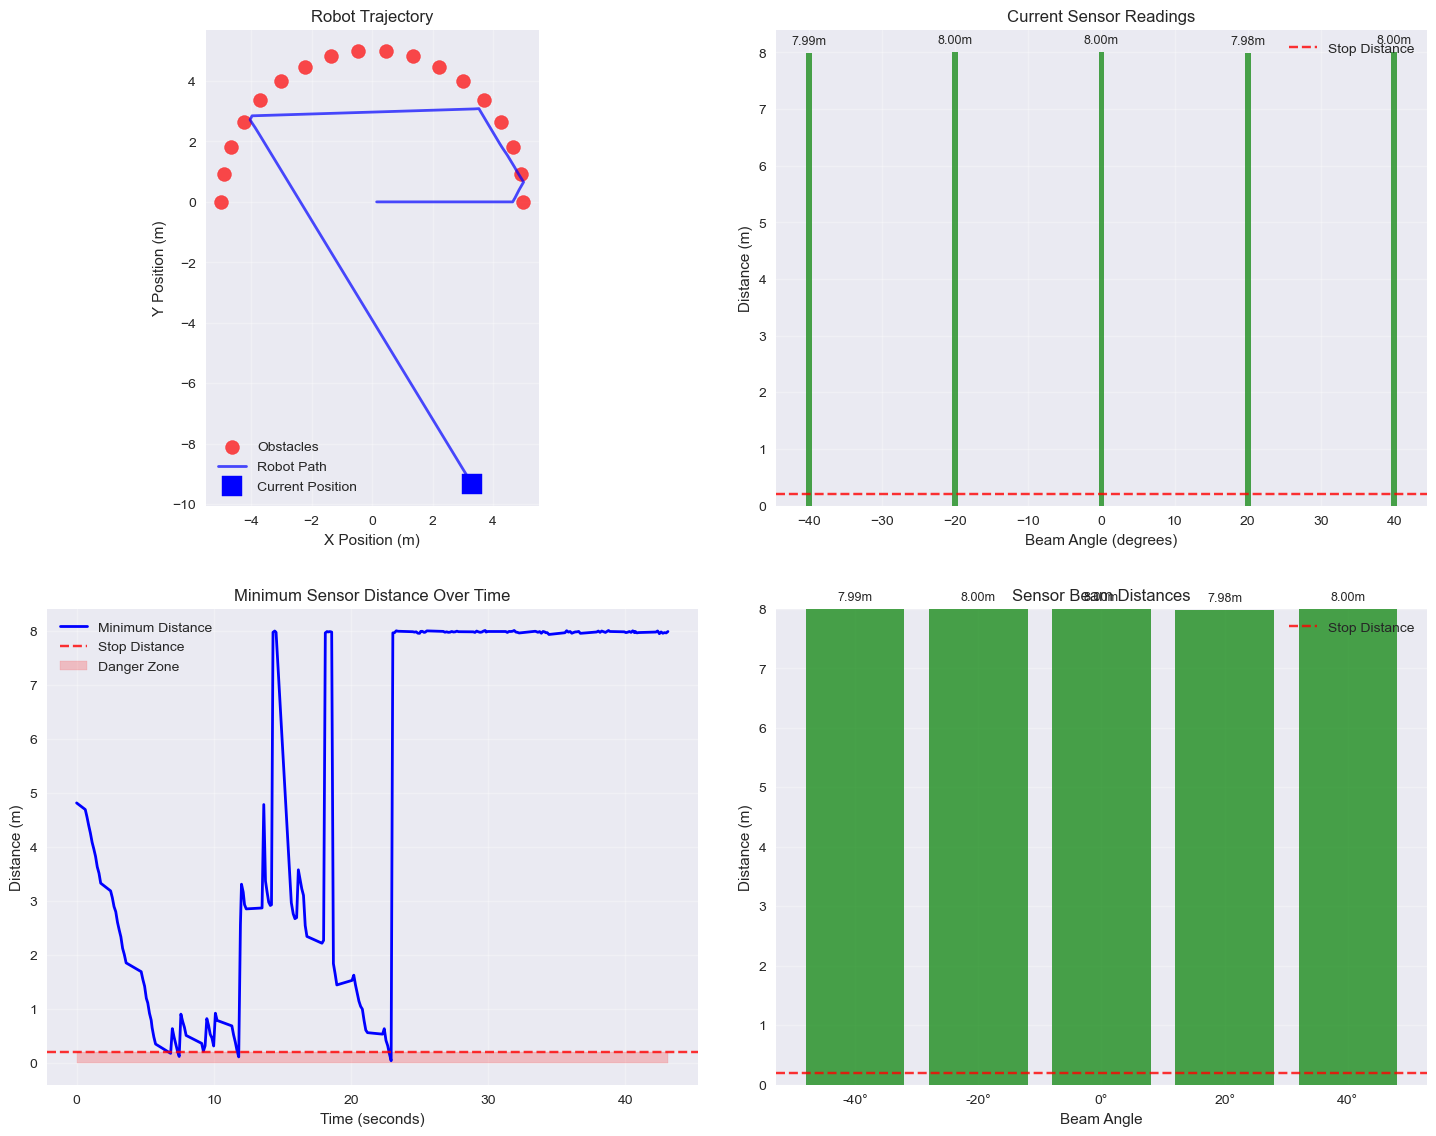

In [5]:
# Simulation parameters
SCAN_RANGE = 8.0
STOP_DISTANCE = 0.2
SENSOR_NOISE_STD = 0.02
SIMULATION_STEPS = 200  # Number of simulation steps
UPDATE_INTERVAL = 10    # Update visualization every N steps

if robot_sim is not None:
    # Create visualizer
    visualizer = SimulationVisualizer(robot_sim)
    
    print("🚀 Starting simulation...")
    print(f"Parameters: Range={SCAN_RANGE}m, Stop Distance={STOP_DISTANCE}m, Noise STD={SENSOR_NOISE_STD}")
    
    try:
        for step in range(SIMULATION_STEPS):
            # Step the physics simulation
            p.stepSimulation()
            p.removeAllUserDebugItems()

            # Cast sensor beams
            pos, beam_data = robot_sim.cast_multiple_beams(SCAN_RANGE, SENSOR_NOISE_STD)
            min_distance = SCAN_RANGE

            # Visualize beams in PyBullet
            for distance, beam_dir, beam_end, angle_deg in beam_data:
                color = [1, 0, 0] if distance < STOP_DISTANCE else [0, 1, 0]
                p.addUserDebugLine(pos, beam_end, color, lineWidth=2, lifeTime=0.1)

                # Add distance labels
                label_pos = [pos[0] + 0.2 * beam_dir[0],
                           pos[1] + 0.2 * beam_dir[1],
                           pos[2] + 0.1]
                p.addUserDebugText(f"{distance:.2f}m", label_pos,
                                 textColorRGB=[0, 0, 0],
                                 textSize=0.7,
                                 lifeTime=0.1)

                min_distance = min(min_distance, distance)

            # Movement decision
            if min_distance < STOP_DISTANCE:
                robot_sim.move_robot(velocity=0.15, turn=True)
            else:
                robot_sim.move_robot(velocity=0.15)

            # Update visualizations periodically
            if step % UPDATE_INTERVAL == 0:
                try:
                    visualizer.update_all_plots()
                except Exception as viz_error:
                    print(f"Visualization error at step {step}: {viz_error}")
                print(f"Step {step}: Min Distance = {min_distance:.3f}m, Position = ({pos[0]:.2f}, {pos[1]:.2f})")

            time.sleep(0.05)
            
    except KeyboardInterrupt:
        print("\n Simulation interrupted by user.")
    except Exception as e:
        print(f"\n Error during simulation: {e}")
    
    # Final visualization update
    try:
        visualizer.update_all_plots()
    except Exception as final_viz_error:
        print(f"Final visualization error: {final_viz_error}")
    print(f"\n Simulation completed! Total steps: {len(robot_sim.sensor_data)}")
    print(f" Data collected: {len(robot_sim.sensor_data)} sensor readings")
    print(f" Path length: {len(robot_sim.robot_positions)} positions")
    
else:
    print(" Cannot run simulation - initialization failed.")


## 5. Data Analysis and Statistics


In [6]:
if robot_sim and robot_sim.sensor_data:
    # Convert sensor data to DataFrame for analysis
    data_records = []
    for i, data in enumerate(robot_sim.sensor_data):
        record = {
            'step': i,
            'timestamp': data['timestamp'] - robot_sim.sensor_data[0]['timestamp'],
            'x_pos': data['robot_pos'][0],
            'y_pos': data['robot_pos'][1],
            'min_distance': data['min_distance'],
            'beam_0': data['distances'][0],  # -40°
            'beam_1': data['distances'][1],  # -20°
            'beam_2': data['distances'][2],  #   0°
            'beam_3': data['distances'][3],  #  20°
            'beam_4': data['distances'][4],  #  40°
        }
        data_records.append(record)
    
    df = pd.DataFrame(data_records)
    
    print(" SIMULATION STATISTICS")
    print("=" * 50)
    print(f"Total simulation time: {df['timestamp'].max():.2f} seconds")
    print(f"Total distance traveled: {np.sum(np.sqrt(np.diff(df['x_pos'])**2 + np.diff(df['y_pos'])**2)):.2f} meters")
    print(f"Average minimum distance: {df['min_distance'].mean():.3f} ± {df['min_distance'].std():.3f} meters")
    print(f"Closest approach to obstacle: {df['min_distance'].min():.3f} meters")
    print(f"Number of close calls (< 0.5m): {(df['min_distance'] < 0.5).sum()}")
    print(f"Number of danger situations (< 0.2m): {(df['min_distance'] < 0.2).sum()}")
    
    # Display first and last few rows of data
    print("\n SENSOR DATA SAMPLE")
    print("=" * 50)
    display(df[['step', 'timestamp', 'x_pos', 'y_pos', 'min_distance']].head())
    print("...")
    display(df[['step', 'timestamp', 'x_pos', 'y_pos', 'min_distance']].tail())
    
else:
    print(" No simulation data available for analysis.")


 SIMULATION STATISTICS
Total simulation time: 43.11 seconds
Total distance traveled: 29.85 meters
Average minimum distance: 4.939 ± 3.215 meters
Closest approach to obstacle: 0.044 meters
Number of close calls (< 0.5m): 19
Number of danger situations (< 0.2m): 5

 SENSOR DATA SAMPLE


,step,timestamp,x_pos,y_pos,min_distance
0,0,0.000000,6.434805e-08,1.730210e-07,4.811353
1,1,0.632293,1.500001e-01,3.070273e-07,4.689107
2,2,0.756828,3.000002e-01,3.883079e-07,4.552920
3,3,0.881685,4.500003e-01,4.168754e-07,4.395889
4,4,1.007064,6.000003e-01,3.927298e-07,4.252570


...


,step,timestamp,x_pos,y_pos,min_distance
195,195,42.609977,2.914304,-8.689804,7.973513
196,196,42.735061,2.992261,-8.817955,7.949144
197,197,42.859390,3.070218,-8.946106,7.960562
198,198,42.985059,3.148175,-9.074257,7.955804
199,199,43.109913,3.226133,-9.202409,7.981085


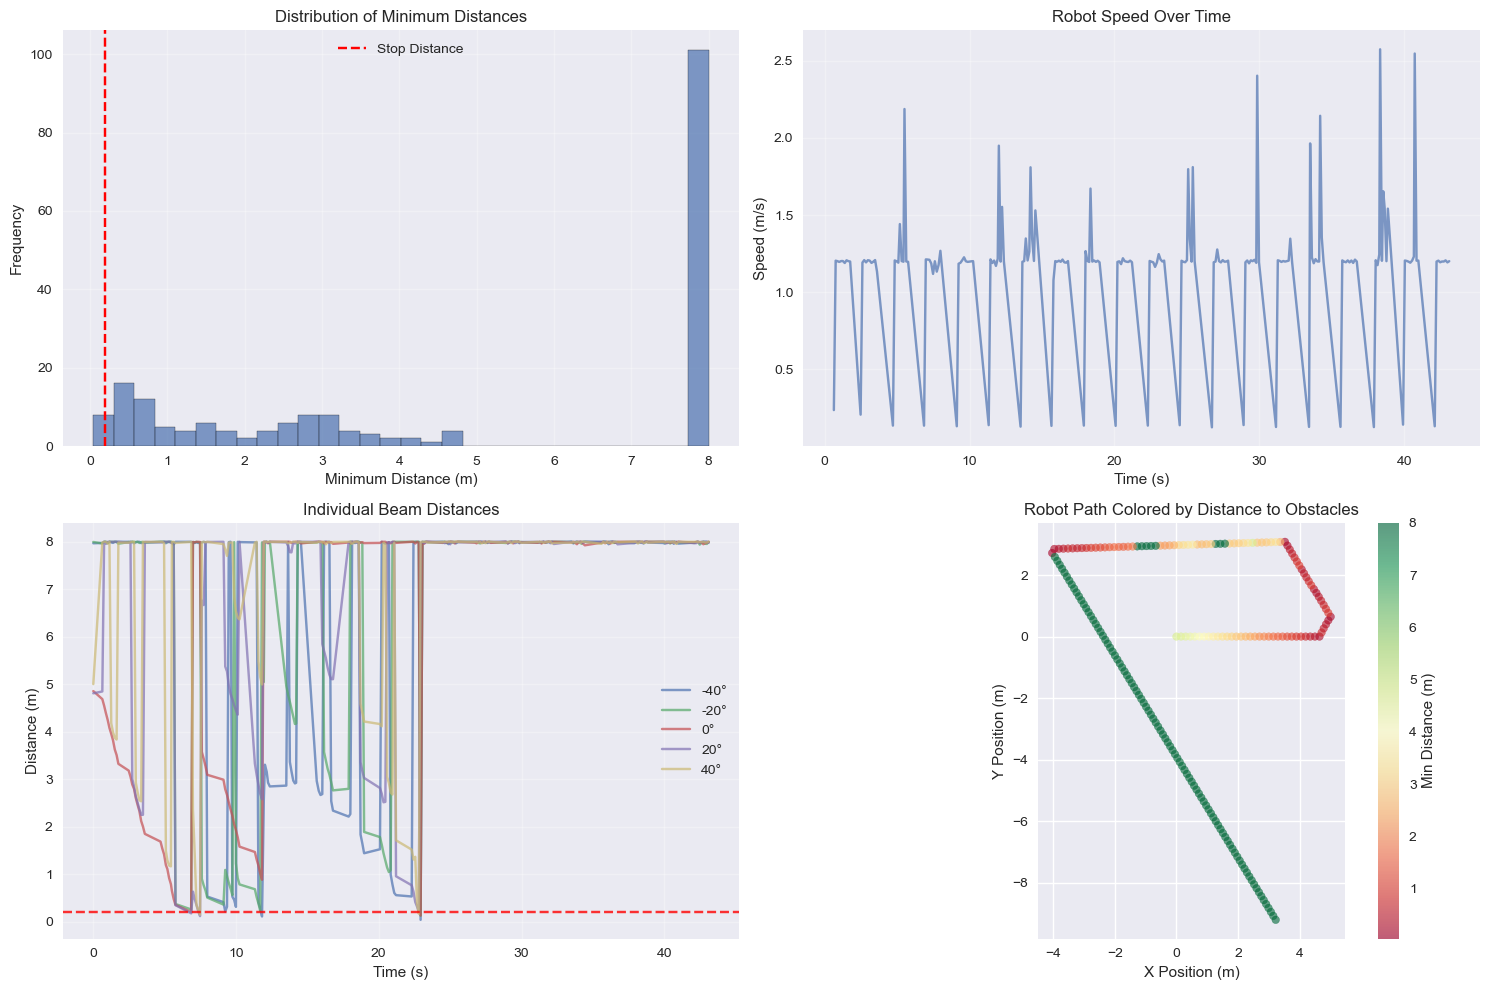

In [7]:
# Additional analysis plots
if robot_sim and robot_sim.sensor_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distance distribution
    axes[0, 0].hist(df['min_distance'], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(0.2, color='red', linestyle='--', label='Stop Distance')
    axes[0, 0].set_xlabel('Minimum Distance (m)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Minimum Distances')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Speed analysis
    speeds = np.sqrt(np.diff(df['x_pos'])**2 + np.diff(df['y_pos'])**2) / np.diff(df['timestamp'])
    axes[0, 1].plot(df['timestamp'][1:], speeds, alpha=0.7)
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Speed (m/s)')
    axes[0, 1].set_title('Robot Speed Over Time')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Beam comparison
    beam_cols = ['beam_0', 'beam_1', 'beam_2', 'beam_3', 'beam_4']
    beam_labels = ['-40°', '-20°', '0°', '20°', '40°']
    for i, (col, label) in enumerate(zip(beam_cols, beam_labels)):
        axes[1, 0].plot(df['timestamp'], df[col], alpha=0.7, label=label)
    axes[1, 0].axhline(0.2, color='red', linestyle='--', alpha=0.8)
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Distance (m)')
    axes[1, 0].set_title('Individual Beam Distances')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Position heatmap
    scatter = axes[1, 1].scatter(df['x_pos'], df['y_pos'], c=df['min_distance'], 
                  cmap='RdYlGn', alpha=0.6, s=30)
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Min Distance (m)')
    axes[1, 1].set_xlabel('X Position (m)')
    axes[1, 1].set_ylabel('Y Position (m)')
    axes[1, 1].set_title('Robot Path Colored by Distance to Obstacles')
    axes[1, 1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()


## 6. Cleanup


In [8]:
# Clean up PyBullet connection
try:
    if p.isConnected():
        p.disconnect()
        print(" PyBullet disconnected cleanly.")
    else:
        print(" PyBullet was not connected or already disconnected.")
except Exception as e:
    print(f" Error during cleanup: {e}")

print("\n Notebook execution completed!")


 PyBullet disconnected cleanly.

 Notebook execution completed!


## Summary

This notebook demonstrated a comprehensive robotics simulation with:

###  **Robot Features:**
- Box robot with realistic physics
- 5-beam sensor system (-40°, -20°, 0°, 20°, 40°)
- Obstacle avoidance behavior
- Sensor noise simulation

###  **Visualizations:**
- Real-time robot trajectory
- Live sensor distance readings
- Polar sensor view
- Historical distance analysis
- Statistical analysis and data export

###  **Key Insights:**
- Robot successfully navigates semi-circular obstacle course
- Sensor fusion provides robust obstacle detection
- Turning behavior activated when obstacles detected within stop distance
- Realistic sensor noise adds complexity to navigation

###  **Data Output:**
- Complete sensor readings over time
- Robot position trajectory
- Performance statistics
- In-memory data analysis
